In [ ]:
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, random_split, DataLoader, Subset
import os
from torch import nn
import torch
from torchvision import transforms


torch.manual_seed(42)


class CustomImageDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir

    def __len__(self):
      _, _, files = next(os.walk(self.img_dir))
      return len(files)
    def __getitem__(self, idx):
        _, _, files = next(os.walk(self.img_dir))
        img_path = files[idx]
        image = read_image(f'{self.img_dir}/{img_path}', ImageReadMode.RGB).float()
        image = image / 255
        return image

In [ ]:
#!unzip 'masks.zip'

In [ ]:
mask_dataset = CustomImageDataset('./masks_1')
print("length of the dataset is:", len(mask_dataset))

train, val = random_split(mask_dataset, [0.8, 0.2])

print("length of the train dataset is:", len(train))
print("length of the val dataset is:", len(val))


batch_size = 32

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size)

length of the dataset is: 4807
length of the train dataset is: 3846
length of the val dataset is: 961


In [ ]:
from torch import flatten, reshape
import torch.nn.functional as F
from torch import nn


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 128, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.norm1 = nn.BatchNorm2d(128)
        self.conv2 = nn.Conv2d(128, 64, 5)
        self.norm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 32, 3)
        self.norm3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 16, 3)
        self.norm4 = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(16, 8, 1)
        self.norm5 = nn.BatchNorm2d(8)
        self.conv6 = nn.Conv2d(8, 4, 1)
        self.norm6 = nn.BatchNorm2d(4)
        self.fc1 = nn.Linear(144, 64)

        self.unfc1 = nn.Linear(64, 144)
        self.upsample = nn.UpsamplingNearest2d(scale_factor=2)
        self.unconv1 = nn.ConvTranspose2d(4, 8, 1)
        self.unconv2 = nn.ConvTranspose2d(8, 16, 1)
        self.unconv3 = nn.ConvTranspose2d(16, 32, 3)
        self.unconv4 = nn.ConvTranspose2d(32, 64, 3)
        self.unconv5 = nn.ConvTranspose2d(64, 128, 5)
        self.unconv6 = nn.ConvTranspose2d(128, 3, 5)
        self.finalUpsample = nn.UpsamplingNearest2d((252, 252))

    def encode(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        x = self.conv4(x)
        x = self.norm4(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        x = self.conv5(x)
        x = self.norm5(x)
        x = F.leaky_relu(x)
        x = self.pool(x)
        x = self.conv6(x)
        x = self.norm6(x)
        x = F.leaky_relu(x)
        x = flatten(x, 1)
        x = self.fc1(x)
        return x

    def decode(self, x):
        x = F.elu(self.unfc1(x))
        x = reshape(x, (-1, 4, 6, 6))
        x = F.elu(self.unconv1(self.upsample(x)))
        x = F.elu(self.unconv2(self.upsample(x)))
        x = F.elu(self.unconv3(self.upsample(x)))
        x = F.elu(self.unconv4(self.upsample(x)))
        x = F.elu(self.unconv5(self.upsample(x)))
        x = F.sigmoid(self.unconv6(self.finalUpsample(x)))
        return x


    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [ ]:
from torchsummary import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'
decoder = AutoEncoder().to(device)
summary(decoder, (3,256, 256,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 252, 252]           9,728
       BatchNorm2d-2        [-1, 128, 252, 252]             256
         MaxPool2d-3        [-1, 128, 126, 126]               0
            Conv2d-4         [-1, 64, 122, 122]         204,864
       BatchNorm2d-5         [-1, 64, 122, 122]             128
         MaxPool2d-6           [-1, 64, 61, 61]               0
            Conv2d-7           [-1, 32, 59, 59]          18,464
       BatchNorm2d-8           [-1, 32, 59, 59]              64
         MaxPool2d-9           [-1, 32, 29, 29]               0
           Conv2d-10           [-1, 16, 27, 27]           4,624
      BatchNorm2d-11           [-1, 16, 27, 27]              32
        MaxPool2d-12           [-1, 16, 13, 13]               0
           Conv2d-13            [-1, 8, 13, 13]             136
      BatchNorm2d-14            [-1, 8,

In [ ]:
import torch.optim as optim

print(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(decoder.parameters(), lr=0.001)

cuda


[1,     1] loss: 0.238
[1,     5] loss: 0.238
[1,     9] loss: 0.234
[1,    13] loss: 0.229
[1,    17] loss: 0.221
[1,    21] loss: 0.217
[1,    25] loss: 0.210
[1,    29] loss: 0.206
[1,    33] loss: 0.203
[1,    37] loss: 0.200
[1,    41] loss: 0.197
[1,    45] loss: 0.194
[1,    49] loss: 0.191
[1,    53] loss: 0.189
[1,    57] loss: 0.186
[1,    61] loss: 0.184
[1,    65] loss: 0.182
[1,    69] loss: 0.180
[1,    73] loss: 0.178
[1,    77] loss: 0.176
[1,    81] loss: 0.174
[1,    85] loss: 0.173
[1,    89] loss: 0.171
[1,    93] loss: 0.170
[1,    97] loss: 0.168
[1,   101] loss: 0.167
[1,   105] loss: 0.166
[1,   109] loss: 0.165
[1,   113] loss: 0.163
[1,   117] loss: 0.162
[1,   121] loss: 0.161
validation
LOSS valid 0.12924903631210327
check


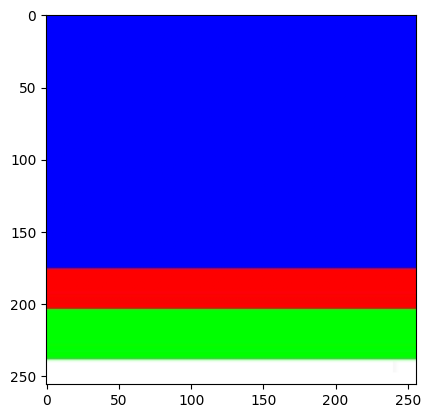

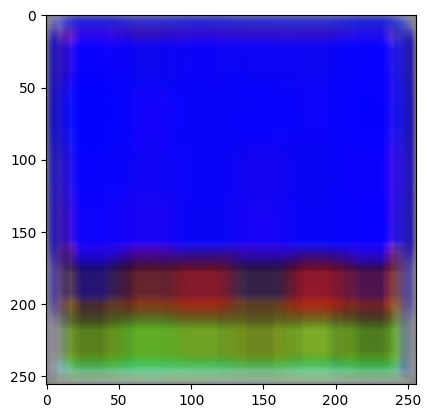

[2,     1] loss: 0.126
[2,     5] loss: 0.136
[2,     9] loss: 0.134
[2,    13] loss: 0.131
[2,    17] loss: 0.129
[2,    21] loss: 0.129
[2,    25] loss: 0.128
[2,    29] loss: 0.126
[2,    33] loss: 0.125
[2,    37] loss: 0.125
[2,    41] loss: 0.125
[2,    45] loss: 0.124
[2,    49] loss: 0.123
[2,    53] loss: 0.123
[2,    57] loss: 0.122
[2,    61] loss: 0.121
[2,    65] loss: 0.120
[2,    69] loss: 0.120
[2,    73] loss: 0.119
[2,    77] loss: 0.119
[2,    81] loss: 0.118
[2,    85] loss: 0.118
[2,    89] loss: 0.117
[2,    93] loss: 0.117
[2,    97] loss: 0.117
[2,   101] loss: 0.116
[2,   105] loss: 0.116
[2,   109] loss: 0.115
[2,   113] loss: 0.115
[2,   117] loss: 0.115
[2,   121] loss: 0.114
validation
LOSS valid 0.10304820537567139
check


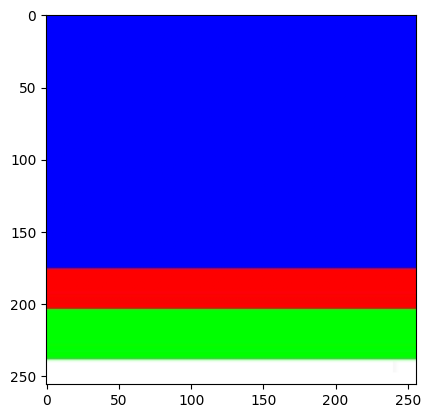

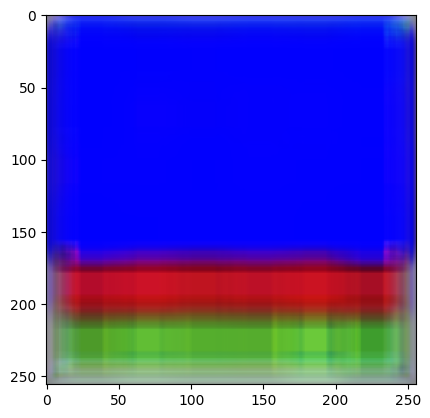

[3,     1] loss: 0.105
[3,     5] loss: 0.105
[3,     9] loss: 0.101
[3,    13] loss: 0.101
[3,    17] loss: 0.101
[3,    21] loss: 0.101
[3,    25] loss: 0.101
[3,    29] loss: 0.101
[3,    33] loss: 0.100
[3,    37] loss: 0.101
[3,    41] loss: 0.101
[3,    45] loss: 0.101
[3,    49] loss: 0.101
[3,    53] loss: 0.101
[3,    57] loss: 0.101
[3,    61] loss: 0.101
[3,    65] loss: 0.101
[3,    69] loss: 0.101
[3,    73] loss: 0.101
[3,    77] loss: 0.100
[3,    81] loss: 0.100
[3,    85] loss: 0.100
[3,    89] loss: 0.099
[3,    93] loss: 0.099
[3,    97] loss: 0.099
[3,   101] loss: 0.099
[3,   105] loss: 0.099
[3,   109] loss: 0.099
[3,   113] loss: 0.099
[3,   117] loss: 0.098
[3,   121] loss: 0.098
validation
LOSS valid 0.09734715521335602
check


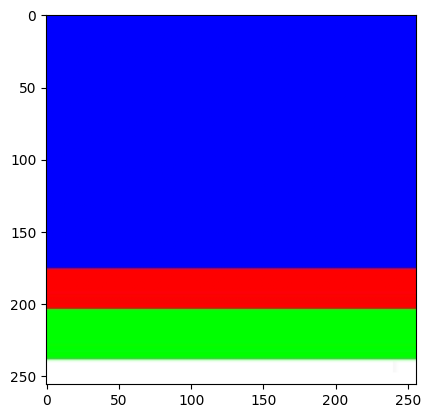

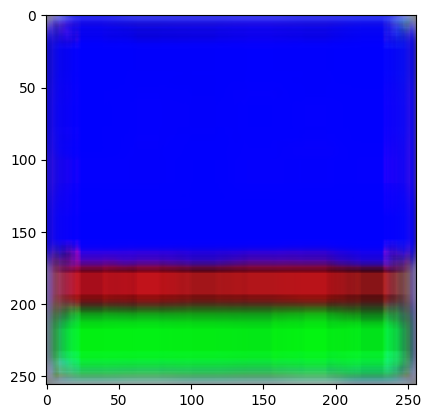

[4,     1] loss: 0.088
[4,     5] loss: 0.090
[4,     9] loss: 0.092
[4,    13] loss: 0.092
[4,    17] loss: 0.092
[4,    21] loss: 0.093
[4,    25] loss: 0.093
[4,    29] loss: 0.093
[4,    33] loss: 0.093
[4,    37] loss: 0.093
[4,    41] loss: 0.093
[4,    45] loss: 0.093
[4,    49] loss: 0.093
[4,    53] loss: 0.093
[4,    57] loss: 0.092
[4,    61] loss: 0.092
[4,    65] loss: 0.092
[4,    69] loss: 0.092
[4,    73] loss: 0.092
[4,    77] loss: 0.092
[4,    81] loss: 0.093
[4,    85] loss: 0.093
[4,    89] loss: 0.093
[4,    93] loss: 0.092
[4,    97] loss: 0.093
[4,   101] loss: 0.092
[4,   105] loss: 0.092
[4,   109] loss: 0.092
[4,   113] loss: 0.092
[4,   117] loss: 0.092
[4,   121] loss: 0.092
validation
LOSS valid 0.09133490920066833
check


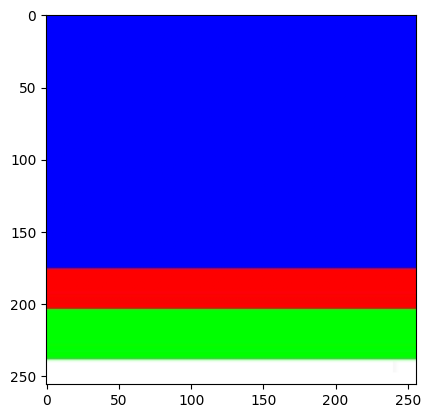

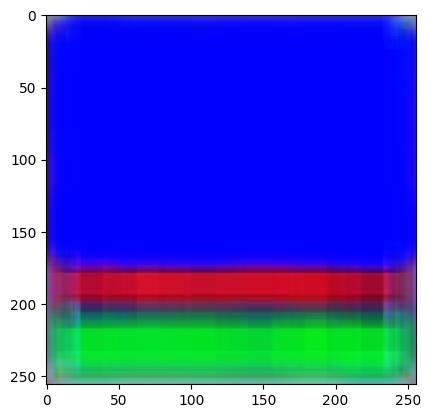

[5,     1] loss: 0.089
[5,     5] loss: 0.090
[5,     9] loss: 0.091
[5,    13] loss: 0.090
[5,    17] loss: 0.090
[5,    21] loss: 0.090
[5,    25] loss: 0.090
[5,    29] loss: 0.090
[5,    33] loss: 0.089
[5,    37] loss: 0.089
[5,    41] loss: 0.089
[5,    45] loss: 0.089
[5,    49] loss: 0.088
[5,    53] loss: 0.088
[5,    57] loss: 0.088
[5,    61] loss: 0.088
[5,    65] loss: 0.088
[5,    69] loss: 0.088
[5,    73] loss: 0.088
[5,    77] loss: 0.088
[5,    81] loss: 0.088
[5,    85] loss: 0.088
[5,    89] loss: 0.088
[5,    93] loss: 0.088
[5,    97] loss: 0.088
[5,   101] loss: 0.088
[5,   105] loss: 0.087
[5,   109] loss: 0.087
[5,   113] loss: 0.087
[5,   117] loss: 0.087
[5,   121] loss: 0.087
validation
LOSS valid 0.08557301014661789
check


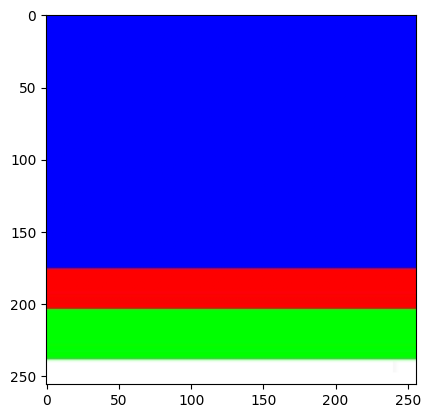

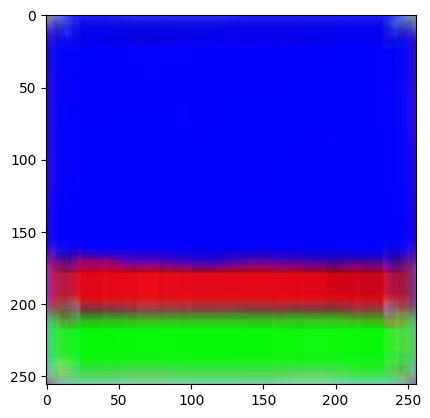

[6,     1] loss: 0.090
[6,     5] loss: 0.091
[6,     9] loss: 0.088
[6,    13] loss: 0.087
[6,    17] loss: 0.087
[6,    21] loss: 0.086
[6,    25] loss: 0.085
[6,    29] loss: 0.085
[6,    33] loss: 0.085
[6,    37] loss: 0.084
[6,    41] loss: 0.085
[6,    45] loss: 0.084
[6,    49] loss: 0.084
[6,    53] loss: 0.084
[6,    57] loss: 0.084
[6,    61] loss: 0.084
[6,    65] loss: 0.084
[6,    69] loss: 0.083
[6,    73] loss: 0.083
[6,    77] loss: 0.083
[6,    81] loss: 0.084
[6,    85] loss: 0.084
[6,    89] loss: 0.084
[6,    93] loss: 0.084
[6,    97] loss: 0.084
[6,   101] loss: 0.084
[6,   105] loss: 0.083
[6,   109] loss: 0.083
[6,   113] loss: 0.083
[6,   117] loss: 0.083
[6,   121] loss: 0.083
validation
LOSS valid 0.08411752432584763
check


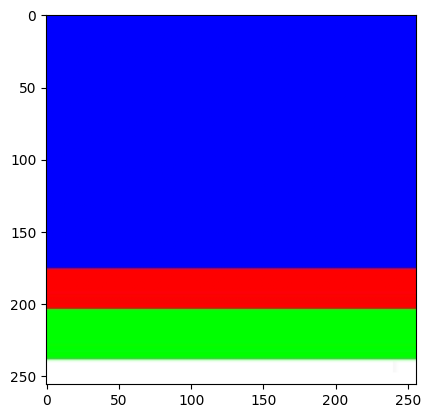

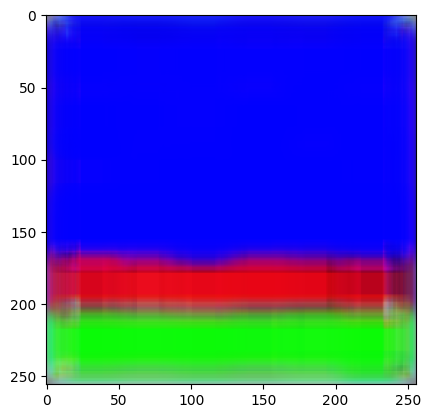

[7,     1] loss: 0.090
[7,     5] loss: 0.085
[7,     9] loss: 0.081
[7,    13] loss: 0.081
[7,    17] loss: 0.081
[7,    21] loss: 0.081
[7,    25] loss: 0.081
[7,    29] loss: 0.081
[7,    33] loss: 0.081
[7,    37] loss: 0.082
[7,    41] loss: 0.081
[7,    45] loss: 0.081
[7,    49] loss: 0.081
[7,    53] loss: 0.081
[7,    57] loss: 0.081
[7,    61] loss: 0.080
[7,    65] loss: 0.080
[7,    69] loss: 0.081
[7,    73] loss: 0.081
[7,    77] loss: 0.081
[7,    81] loss: 0.080
[7,    85] loss: 0.080
[7,    89] loss: 0.080
[7,    93] loss: 0.080
[7,    97] loss: 0.080
[7,   101] loss: 0.080
[7,   105] loss: 0.080
[7,   109] loss: 0.080
[7,   113] loss: 0.080
[7,   117] loss: 0.080
[7,   121] loss: 0.080
validation
LOSS valid 0.07896076887845993
check


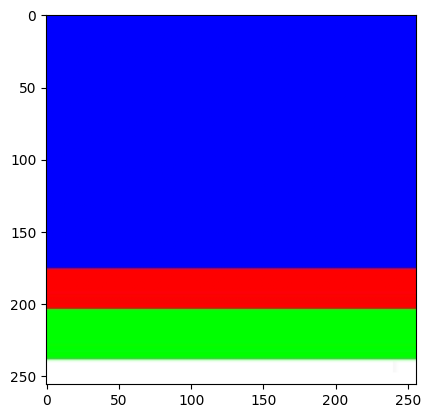

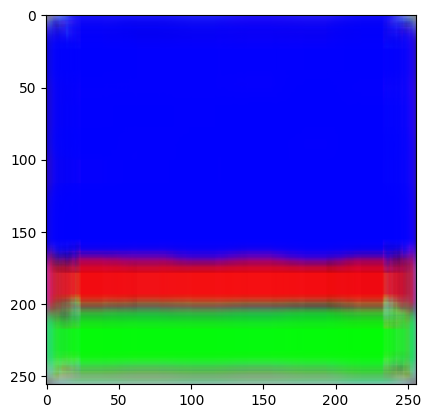

[8,     1] loss: 0.086
[8,     5] loss: 0.082
[8,     9] loss: 0.079
[8,    13] loss: 0.080
[8,    17] loss: 0.080
[8,    21] loss: 0.079
[8,    25] loss: 0.079
[8,    29] loss: 0.080
[8,    33] loss: 0.080
[8,    37] loss: 0.079
[8,    41] loss: 0.079
[8,    45] loss: 0.079
[8,    49] loss: 0.079
[8,    53] loss: 0.079
[8,    57] loss: 0.079
[8,    61] loss: 0.079
[8,    65] loss: 0.079
[8,    69] loss: 0.079
[8,    73] loss: 0.079
[8,    77] loss: 0.078
[8,    81] loss: 0.078
[8,    85] loss: 0.078
[8,    89] loss: 0.078
[8,    93] loss: 0.078
[8,    97] loss: 0.078
[8,   101] loss: 0.078
[8,   105] loss: 0.078
[8,   109] loss: 0.077
[8,   113] loss: 0.077
[8,   117] loss: 0.077
[8,   121] loss: 0.077
validation
LOSS valid 0.0764642283320427
check


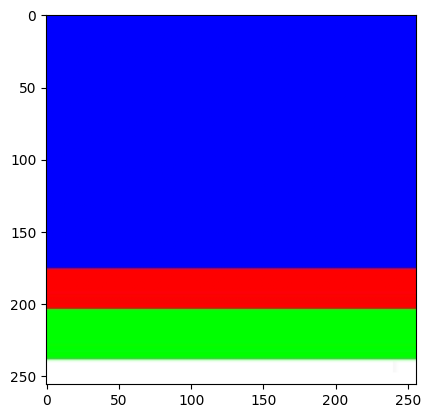

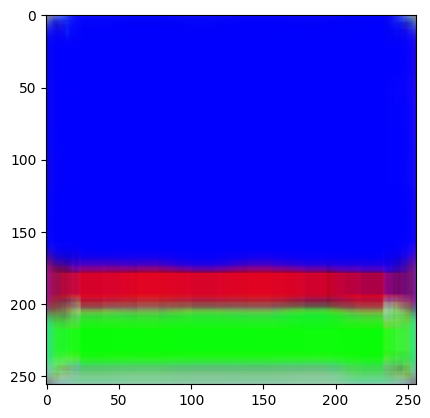

[9,     1] loss: 0.073
[9,     5] loss: 0.078
[9,     9] loss: 0.078
[9,    13] loss: 0.077
[9,    17] loss: 0.077
[9,    21] loss: 0.077
[9,    25] loss: 0.077
[9,    29] loss: 0.076
[9,    33] loss: 0.076
[9,    37] loss: 0.076
[9,    41] loss: 0.076
[9,    45] loss: 0.076
[9,    49] loss: 0.075
[9,    53] loss: 0.075
[9,    57] loss: 0.075
[9,    61] loss: 0.075
[9,    65] loss: 0.075
[9,    69] loss: 0.075
[9,    73] loss: 0.075
[9,    77] loss: 0.076
[9,    81] loss: 0.075
[9,    85] loss: 0.076
[9,    89] loss: 0.075
[9,    93] loss: 0.076
[9,    97] loss: 0.076
[9,   101] loss: 0.076
[9,   105] loss: 0.075
[9,   109] loss: 0.075
[9,   113] loss: 0.075
[9,   117] loss: 0.075
[9,   121] loss: 0.076
validation
LOSS valid 0.07540193945169449
check


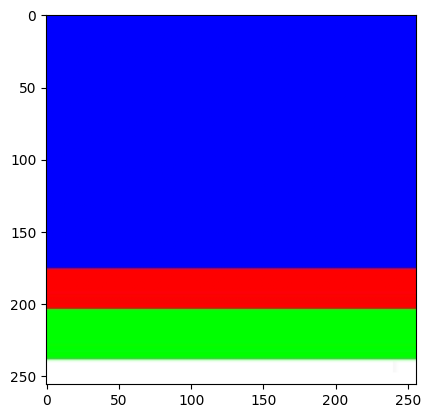

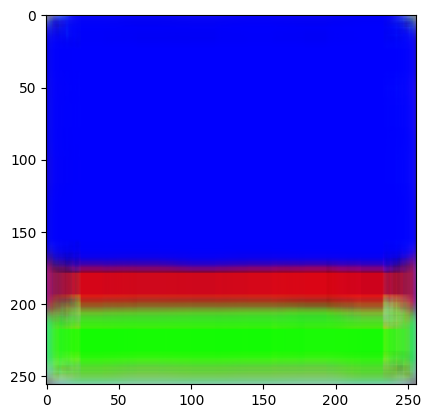

[10,     1] loss: 0.071
[10,     5] loss: 0.079
[10,     9] loss: 0.080
[10,    13] loss: 0.079
[10,    17] loss: 0.078
[10,    21] loss: 0.077
[10,    25] loss: 0.077
[10,    29] loss: 0.077
[10,    33] loss: 0.077
[10,    37] loss: 0.077
[10,    41] loss: 0.076
[10,    45] loss: 0.076
[10,    49] loss: 0.075
[10,    53] loss: 0.075
[10,    57] loss: 0.075
[10,    61] loss: 0.075
[10,    65] loss: 0.075
[10,    69] loss: 0.075
[10,    73] loss: 0.075
[10,    77] loss: 0.074
[10,    81] loss: 0.074
[10,    85] loss: 0.074
[10,    89] loss: 0.074
[10,    93] loss: 0.074
[10,    97] loss: 0.074
[10,   101] loss: 0.074
[10,   105] loss: 0.074
[10,   109] loss: 0.074
[10,   113] loss: 0.074
[10,   117] loss: 0.074
[10,   121] loss: 0.074
validation
LOSS valid 0.07374929636716843
check


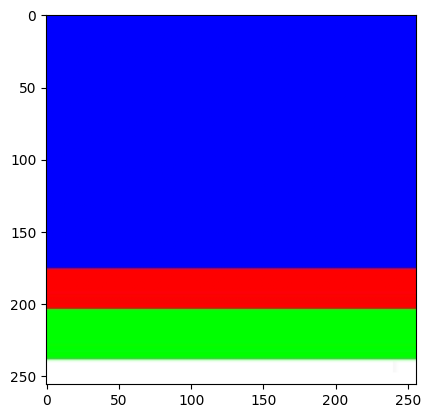

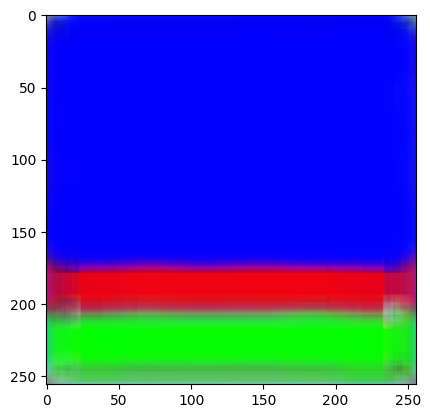

[11,     1] loss: 0.067
[11,     5] loss: 0.072
[11,     9] loss: 0.072
[11,    13] loss: 0.072
[11,    17] loss: 0.072
[11,    21] loss: 0.073
[11,    25] loss: 0.073
[11,    29] loss: 0.073
[11,    33] loss: 0.073
[11,    37] loss: 0.072
[11,    41] loss: 0.072
[11,    45] loss: 0.072
[11,    49] loss: 0.072
[11,    53] loss: 0.072
[11,    57] loss: 0.072
[11,    61] loss: 0.072
[11,    65] loss: 0.072
[11,    69] loss: 0.072
[11,    73] loss: 0.072
[11,    77] loss: 0.072
[11,    81] loss: 0.072
[11,    85] loss: 0.072
[11,    89] loss: 0.072
[11,    93] loss: 0.072
[11,    97] loss: 0.072
[11,   101] loss: 0.072
[11,   105] loss: 0.072
[11,   109] loss: 0.072
[11,   113] loss: 0.072
[11,   117] loss: 0.072
[11,   121] loss: 0.072
validation
LOSS valid 0.07158767431974411
check


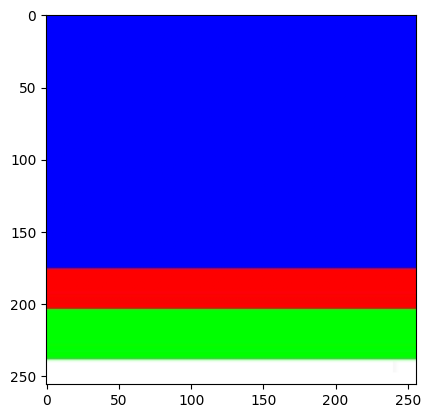

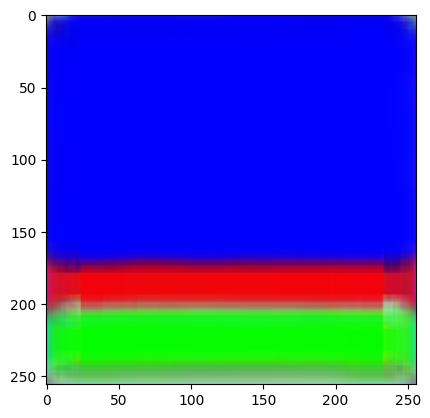

[12,     1] loss: 0.069
[12,     5] loss: 0.072
[12,     9] loss: 0.071
[12,    13] loss: 0.071
[12,    17] loss: 0.070
[12,    21] loss: 0.069
[12,    25] loss: 0.070
[12,    29] loss: 0.070
[12,    33] loss: 0.070
[12,    37] loss: 0.070
[12,    41] loss: 0.070
[12,    45] loss: 0.070
[12,    49] loss: 0.070
[12,    53] loss: 0.070
[12,    57] loss: 0.070
[12,    61] loss: 0.070
[12,    65] loss: 0.070
[12,    69] loss: 0.070
[12,    73] loss: 0.070
[12,    77] loss: 0.071
[12,    81] loss: 0.071
[12,    85] loss: 0.071
[12,    89] loss: 0.071
[12,    93] loss: 0.071
[12,    97] loss: 0.071
[12,   101] loss: 0.071
[12,   105] loss: 0.071
[12,   109] loss: 0.071
[12,   113] loss: 0.071
[12,   117] loss: 0.071
[12,   121] loss: 0.071
validation
LOSS valid 0.06957034021615982
check


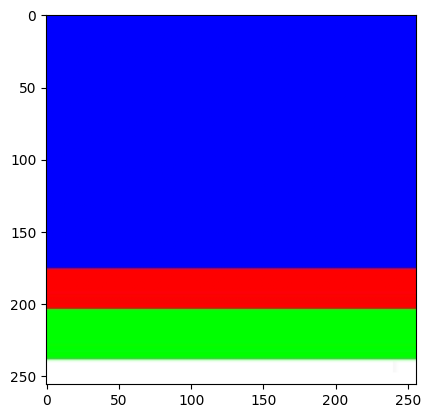

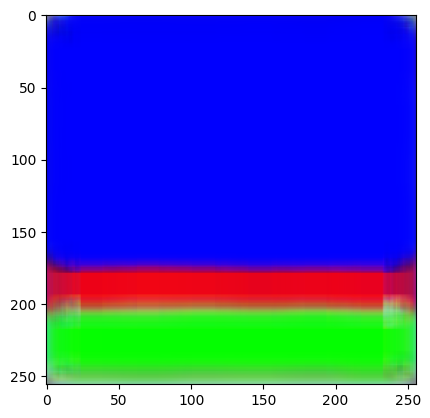

[13,     1] loss: 0.070
[13,     5] loss: 0.068
[13,     9] loss: 0.070
[13,    13] loss: 0.071
[13,    17] loss: 0.072
[13,    21] loss: 0.071
[13,    25] loss: 0.070
[13,    29] loss: 0.069
[13,    33] loss: 0.070
[13,    37] loss: 0.069
[13,    41] loss: 0.070
[13,    45] loss: 0.069
[13,    49] loss: 0.070
[13,    53] loss: 0.070
[13,    57] loss: 0.070
[13,    61] loss: 0.070
[13,    65] loss: 0.070
[13,    69] loss: 0.070
[13,    73] loss: 0.070
[13,    77] loss: 0.070
[13,    81] loss: 0.070
[13,    85] loss: 0.070
[13,    89] loss: 0.070
[13,    93] loss: 0.070
[13,    97] loss: 0.070
[13,   101] loss: 0.070
[13,   105] loss: 0.070
[13,   109] loss: 0.070
[13,   113] loss: 0.070
[13,   117] loss: 0.069
[13,   121] loss: 0.070
validation
LOSS valid 0.06987904757261276
[14,     1] loss: 0.068
[14,     5] loss: 0.068
[14,     9] loss: 0.071
[14,    13] loss: 0.071
[14,    17] loss: 0.071
[14,    21] loss: 0.070
[14,    25] loss: 0.070
[14,    29] loss: 0.069
[14,    33] loss: 0.06

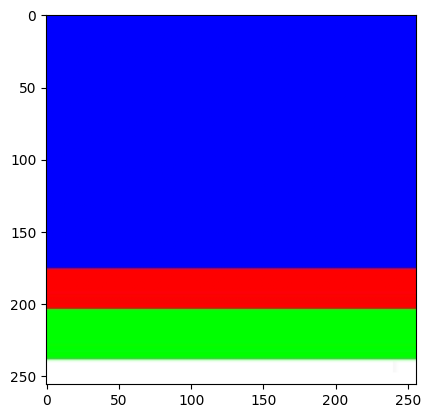

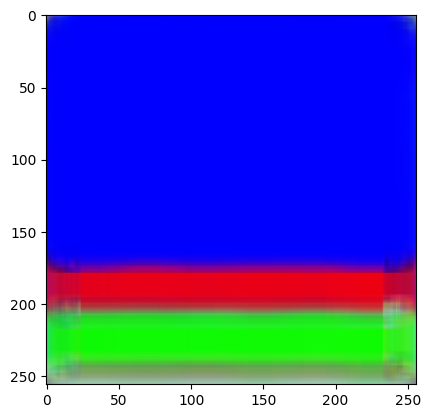

[16,     1] loss: 0.070
[16,     5] loss: 0.073
[16,     9] loss: 0.069
[16,    13] loss: 0.069
[16,    17] loss: 0.067
[16,    21] loss: 0.066
[16,    25] loss: 0.066
[16,    29] loss: 0.066
[16,    33] loss: 0.066
[16,    37] loss: 0.066
[16,    41] loss: 0.066
[16,    45] loss: 0.066
[16,    49] loss: 0.066
[16,    53] loss: 0.066
[16,    57] loss: 0.066
[16,    61] loss: 0.066
[16,    65] loss: 0.066
[16,    69] loss: 0.067
[16,    73] loss: 0.067
[16,    77] loss: 0.067
[16,    81] loss: 0.067
[16,    85] loss: 0.067
[16,    89] loss: 0.067
[16,    93] loss: 0.067
[16,    97] loss: 0.067
[16,   101] loss: 0.066
[16,   105] loss: 0.066
[16,   109] loss: 0.066
[16,   113] loss: 0.066
[16,   117] loss: 0.067
[16,   121] loss: 0.067
validation
LOSS valid 0.07005635648965836
[17,     1] loss: 0.083
[17,     5] loss: 0.072
[17,     9] loss: 0.073
[17,    13] loss: 0.072
[17,    17] loss: 0.071
[17,    21] loss: 0.071
[17,    25] loss: 0.071
[17,    29] loss: 0.070
[17,    33] loss: 0.07

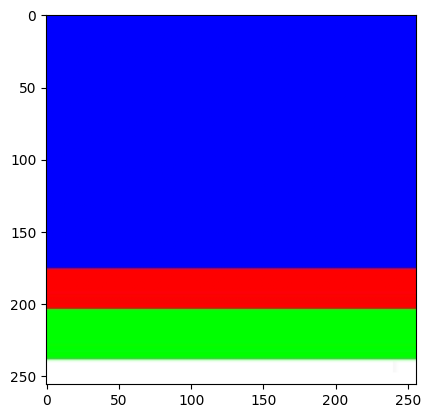

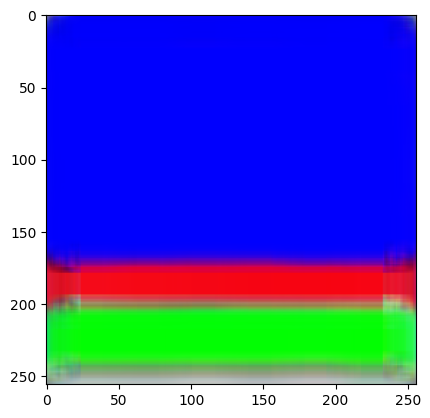

[18,     1] loss: 0.063
[18,     5] loss: 0.064
[18,     9] loss: 0.064
[18,    13] loss: 0.063
[18,    17] loss: 0.063
[18,    21] loss: 0.064
[18,    25] loss: 0.065
[18,    29] loss: 0.065
[18,    33] loss: 0.065
[18,    37] loss: 0.065
[18,    41] loss: 0.064
[18,    45] loss: 0.064
[18,    49] loss: 0.064
[18,    53] loss: 0.064
[18,    57] loss: 0.065
[18,    61] loss: 0.065
[18,    65] loss: 0.065
[18,    69] loss: 0.065
[18,    73] loss: 0.065
[18,    77] loss: 0.065
[18,    81] loss: 0.065
[18,    85] loss: 0.065
[18,    89] loss: 0.065
[18,    93] loss: 0.065
[18,    97] loss: 0.065
[18,   101] loss: 0.065
[18,   105] loss: 0.065
[18,   109] loss: 0.065
[18,   113] loss: 0.065
[18,   117] loss: 0.065
[18,   121] loss: 0.065
validation
LOSS valid 0.0671764463186264
[19,     1] loss: 0.070
[19,     5] loss: 0.069
[19,     9] loss: 0.067
[19,    13] loss: 0.065
[19,    17] loss: 0.065
[19,    21] loss: 0.064
[19,    25] loss: 0.064
[19,    29] loss: 0.064
[19,    33] loss: 0.064

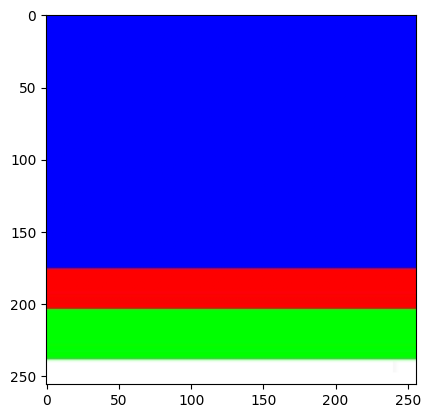

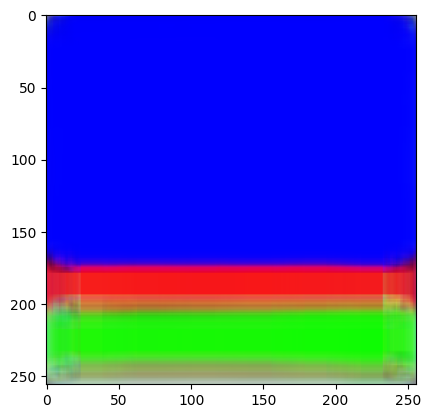

[20,     1] loss: 0.061
[20,     5] loss: 0.061
[20,     9] loss: 0.063
[20,    13] loss: 0.064
[20,    17] loss: 0.063
[20,    21] loss: 0.064
[20,    25] loss: 0.064
[20,    29] loss: 0.064
[20,    33] loss: 0.064
[20,    37] loss: 0.064
[20,    41] loss: 0.064
[20,    45] loss: 0.064
[20,    49] loss: 0.064
[20,    53] loss: 0.064
[20,    57] loss: 0.064
[20,    61] loss: 0.065
[20,    65] loss: 0.065
[20,    69] loss: 0.064
[20,    73] loss: 0.064
[20,    77] loss: 0.064
[20,    81] loss: 0.064
[20,    85] loss: 0.064
[20,    89] loss: 0.064
[20,    93] loss: 0.064
[20,    97] loss: 0.064
[20,   101] loss: 0.064
[20,   105] loss: 0.064
[20,   109] loss: 0.064
[20,   113] loss: 0.064
[20,   117] loss: 0.064
[20,   121] loss: 0.064
validation
LOSS valid 0.06563806533813477
[21,     1] loss: 0.071
[21,     5] loss: 0.064
[21,     9] loss: 0.063
[21,    13] loss: 0.063
[21,    17] loss: 0.063
[21,    21] loss: 0.062
[21,    25] loss: 0.062
[21,    29] loss: 0.063
[21,    33] loss: 0.06

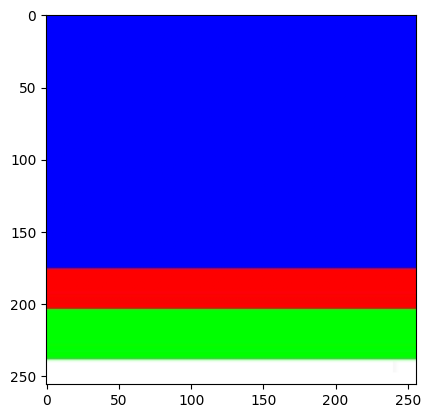

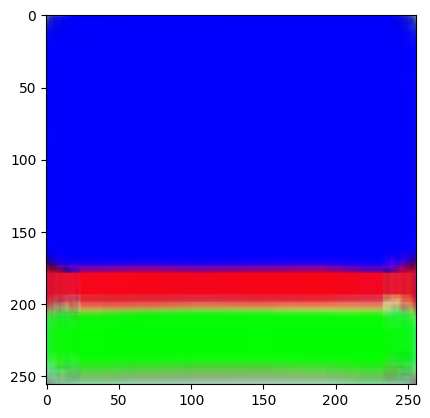

[22,     1] loss: 0.067
[22,     5] loss: 0.064
[22,     9] loss: 0.063
[22,    13] loss: 0.063
[22,    17] loss: 0.064
[22,    21] loss: 0.064
[22,    25] loss: 0.065
[22,    29] loss: 0.064
[22,    33] loss: 0.065
[22,    37] loss: 0.065
[22,    41] loss: 0.064
[22,    45] loss: 0.065
[22,    49] loss: 0.065
[22,    53] loss: 0.065
[22,    57] loss: 0.065
[22,    61] loss: 0.065
[22,    65] loss: 0.065
[22,    69] loss: 0.064
[22,    73] loss: 0.064
[22,    77] loss: 0.064
[22,    81] loss: 0.064
[22,    85] loss: 0.064
[22,    89] loss: 0.064
[22,    93] loss: 0.063
[22,    97] loss: 0.063
[22,   101] loss: 0.063
[22,   105] loss: 0.063
[22,   109] loss: 0.063
[22,   113] loss: 0.063
[22,   117] loss: 0.063
[22,   121] loss: 0.063
validation
LOSS valid 0.06408313661813736
[23,     1] loss: 0.060
[23,     5] loss: 0.067
[23,     9] loss: 0.064
[23,    13] loss: 0.066
[23,    17] loss: 0.066
[23,    21] loss: 0.065
[23,    25] loss: 0.065
[23,    29] loss: 0.064
[23,    33] loss: 0.06

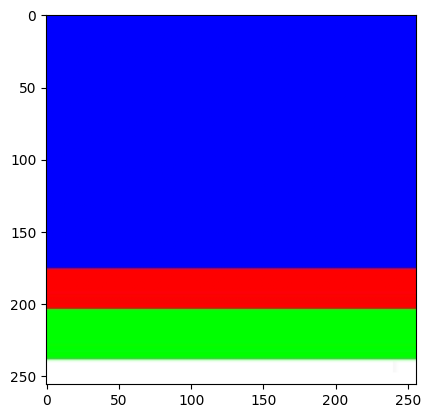

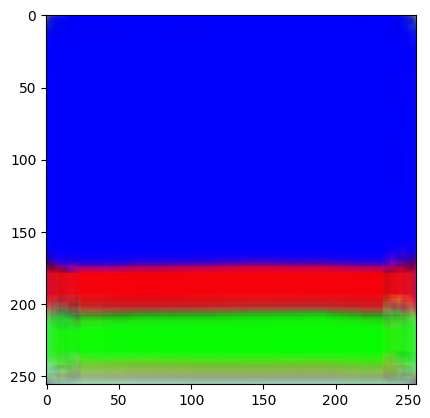

[24,     1] loss: 0.063
[24,     5] loss: 0.059
[24,     9] loss: 0.061
[24,    13] loss: 0.060
[24,    17] loss: 0.061
[24,    21] loss: 0.061
[24,    25] loss: 0.061
[24,    29] loss: 0.061
[24,    33] loss: 0.061
[24,    37] loss: 0.062
[24,    41] loss: 0.061
[24,    45] loss: 0.061
[24,    49] loss: 0.062
[24,    53] loss: 0.062
[24,    57] loss: 0.062
[24,    61] loss: 0.062
[24,    65] loss: 0.062
[24,    69] loss: 0.062
[24,    73] loss: 0.062
[24,    77] loss: 0.062
[24,    81] loss: 0.062
[24,    85] loss: 0.062
[24,    89] loss: 0.062
[24,    93] loss: 0.062
[24,    97] loss: 0.062
[24,   101] loss: 0.062
[24,   105] loss: 0.062
[24,   109] loss: 0.062
[24,   113] loss: 0.062
[24,   117] loss: 0.062
[24,   121] loss: 0.062
validation
LOSS valid 0.06360393762588501
check


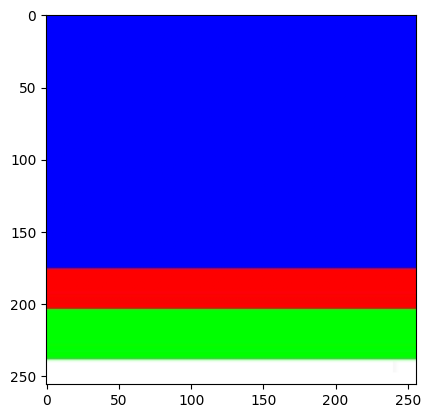

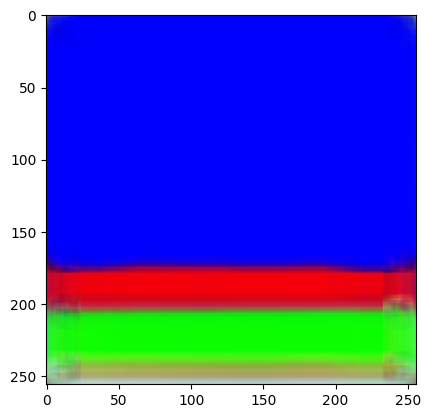

[25,     1] loss: 0.061
[25,     5] loss: 0.066
[25,     9] loss: 0.064
[25,    13] loss: 0.063
[25,    17] loss: 0.062
[25,    21] loss: 0.063
[25,    25] loss: 0.063
[25,    29] loss: 0.063
[25,    33] loss: 0.063
[25,    37] loss: 0.063
[25,    41] loss: 0.062
[25,    45] loss: 0.062
[25,    49] loss: 0.062
[25,    53] loss: 0.062
[25,    57] loss: 0.062
[25,    61] loss: 0.062
[25,    65] loss: 0.062
[25,    69] loss: 0.062
[25,    73] loss: 0.062
[25,    77] loss: 0.062
[25,    81] loss: 0.061
[25,    85] loss: 0.061
[25,    89] loss: 0.061
[25,    93] loss: 0.061
[25,    97] loss: 0.061
[25,   101] loss: 0.062
[25,   105] loss: 0.062
[25,   109] loss: 0.062
[25,   113] loss: 0.062
[25,   117] loss: 0.062
[25,   121] loss: 0.061
validation
LOSS valid 0.06279665976762772
check


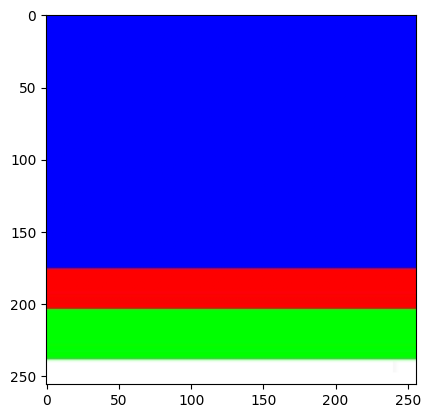

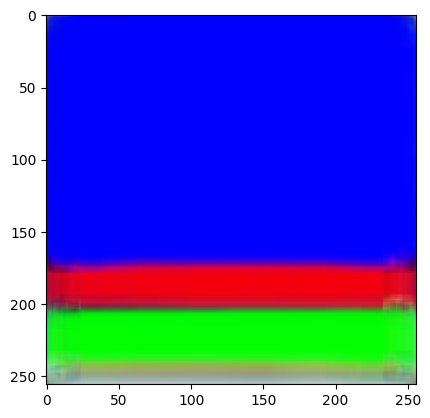

[26,     1] loss: 0.056
[26,     5] loss: 0.059
[26,     9] loss: 0.061
[26,    13] loss: 0.060
[26,    17] loss: 0.060
[26,    21] loss: 0.061
[26,    25] loss: 0.060
[26,    29] loss: 0.061
[26,    33] loss: 0.062
[26,    37] loss: 0.062
[26,    41] loss: 0.062
[26,    45] loss: 0.062
[26,    49] loss: 0.062
[26,    53] loss: 0.062
[26,    57] loss: 0.062
[26,    61] loss: 0.061
[26,    65] loss: 0.061
[26,    69] loss: 0.061
[26,    73] loss: 0.061
[26,    77] loss: 0.061
[26,    81] loss: 0.061
[26,    85] loss: 0.061
[26,    89] loss: 0.061
[26,    93] loss: 0.061
[26,    97] loss: 0.061
[26,   101] loss: 0.061
[26,   105] loss: 0.062
[26,   109] loss: 0.061
[26,   113] loss: 0.061
[26,   117] loss: 0.061
[26,   121] loss: 0.061
validation
LOSS valid 0.06280066817998886
[27,     1] loss: 0.058
[27,     5] loss: 0.062
[27,     9] loss: 0.061
[27,    13] loss: 0.062
[27,    17] loss: 0.062
[27,    21] loss: 0.061
[27,    25] loss: 0.061
[27,    29] loss: 0.062
[27,    33] loss: 0.06

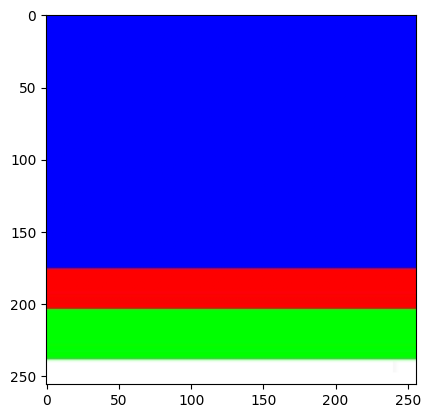

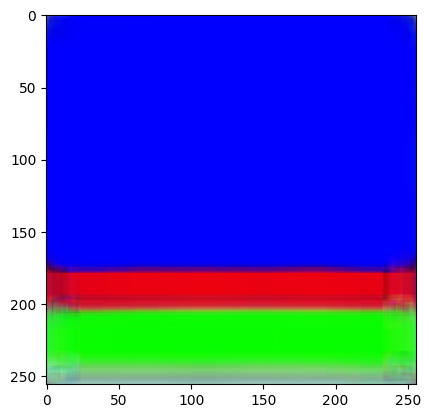

[30,     1] loss: 0.047
[30,     5] loss: 0.057
[30,     9] loss: 0.058
[30,    13] loss: 0.059
[30,    17] loss: 0.058
[30,    21] loss: 0.059
[30,    25] loss: 0.060
[30,    29] loss: 0.060
[30,    33] loss: 0.060
[30,    37] loss: 0.060
[30,    41] loss: 0.061
[30,    45] loss: 0.061
[30,    49] loss: 0.060
[30,    53] loss: 0.060
[30,    57] loss: 0.060
[30,    61] loss: 0.060
[30,    65] loss: 0.061
[30,    69] loss: 0.060
[30,    73] loss: 0.060
[30,    77] loss: 0.060
[30,    81] loss: 0.060
[30,    85] loss: 0.060
[30,    89] loss: 0.060
[30,    93] loss: 0.060
[30,    97] loss: 0.060
[30,   101] loss: 0.060
[30,   105] loss: 0.060
[30,   109] loss: 0.060
[30,   113] loss: 0.060
[30,   117] loss: 0.060
[30,   121] loss: 0.060
validation
LOSS valid 0.06311268359422684
[31,     1] loss: 0.059
[31,     5] loss: 0.064
[31,     9] loss: 0.064
[31,    13] loss: 0.065
[31,    17] loss: 0.064
[31,    21] loss: 0.063
[31,    25] loss: 0.062
[31,    29] loss: 0.062
[31,    33] loss: 0.06

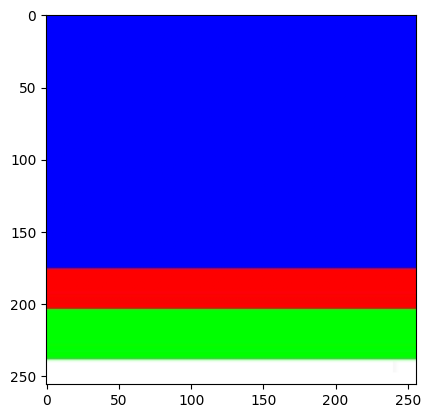

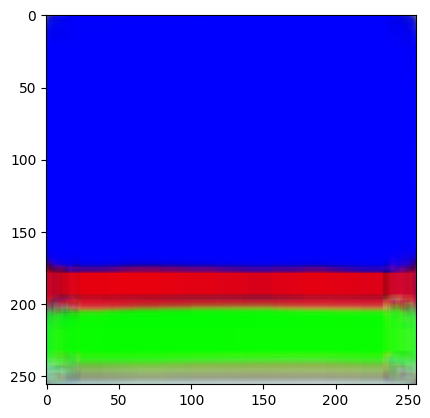

[33,     1] loss: 0.063
[33,     5] loss: 0.063
[33,     9] loss: 0.061
[33,    13] loss: 0.059
[33,    17] loss: 0.061
[33,    21] loss: 0.061
[33,    25] loss: 0.060
[33,    29] loss: 0.060
[33,    33] loss: 0.060
[33,    37] loss: 0.060
[33,    41] loss: 0.060
[33,    45] loss: 0.060
[33,    49] loss: 0.060
[33,    53] loss: 0.060
[33,    57] loss: 0.060
[33,    61] loss: 0.060
[33,    65] loss: 0.060
[33,    69] loss: 0.060
[33,    73] loss: 0.060
[33,    77] loss: 0.060
[33,    81] loss: 0.060
[33,    85] loss: 0.060
[33,    89] loss: 0.060
[33,    93] loss: 0.060
[33,    97] loss: 0.060
[33,   101] loss: 0.060
[33,   105] loss: 0.060
[33,   109] loss: 0.060
[33,   113] loss: 0.060
[33,   117] loss: 0.060
[33,   121] loss: 0.060
validation
LOSS valid 0.0612373873591423
check


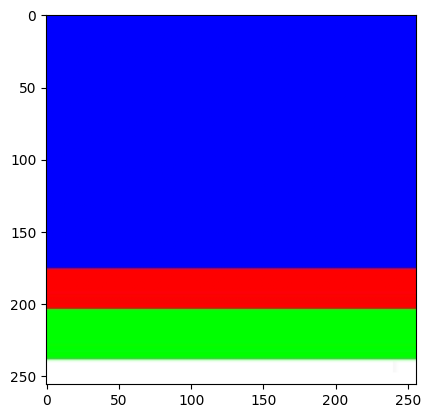

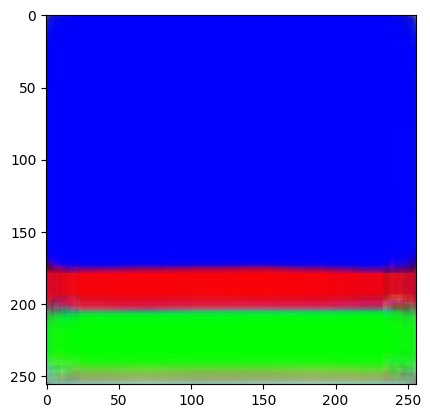

[34,     1] loss: 0.053
[34,     5] loss: 0.058
[34,     9] loss: 0.058
[34,    13] loss: 0.056
[34,    17] loss: 0.057
[34,    21] loss: 0.058
[34,    25] loss: 0.058
[34,    29] loss: 0.058
[34,    33] loss: 0.058
[34,    37] loss: 0.059
[34,    41] loss: 0.058
[34,    45] loss: 0.059
[34,    49] loss: 0.059
[34,    53] loss: 0.059
[34,    57] loss: 0.059
[34,    61] loss: 0.058
[34,    65] loss: 0.058
[34,    69] loss: 0.058
[34,    73] loss: 0.058
[34,    77] loss: 0.058
[34,    81] loss: 0.059
[34,    85] loss: 0.059
[34,    89] loss: 0.059
[34,    93] loss: 0.059
[34,    97] loss: 0.059
[34,   101] loss: 0.059
[34,   105] loss: 0.059
[34,   109] loss: 0.059
[34,   113] loss: 0.059
[34,   117] loss: 0.059
[34,   121] loss: 0.059
validation
LOSS valid 0.061287034302949905
[35,     1] loss: 0.064
[35,     5] loss: 0.061
[35,     9] loss: 0.062
[35,    13] loss: 0.062
[35,    17] loss: 0.062
[35,    21] loss: 0.061
[35,    25] loss: 0.061
[35,    29] loss: 0.060
[35,    33] loss: 0.0

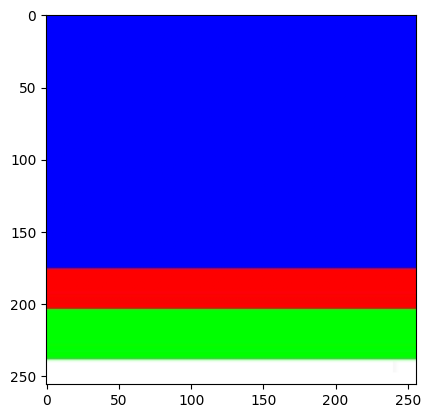

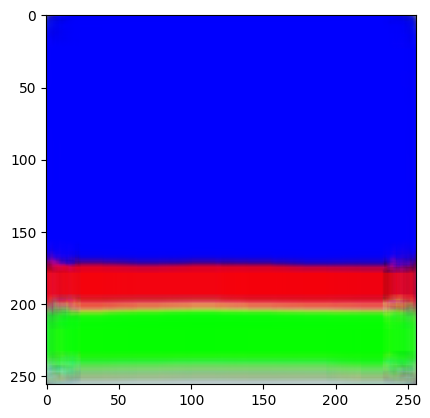

[36,     1] loss: 0.073
[36,     5] loss: 0.065
[36,     9] loss: 0.062
[36,    13] loss: 0.062
[36,    17] loss: 0.061
[36,    21] loss: 0.060
[36,    25] loss: 0.060
[36,    29] loss: 0.060
[36,    33] loss: 0.059
[36,    37] loss: 0.060
[36,    41] loss: 0.060
[36,    45] loss: 0.060
[36,    49] loss: 0.059
[36,    53] loss: 0.060
[36,    57] loss: 0.059
[36,    61] loss: 0.059
[36,    65] loss: 0.059
[36,    69] loss: 0.059
[36,    73] loss: 0.059
[36,    77] loss: 0.058
[36,    81] loss: 0.058
[36,    85] loss: 0.058
[36,    89] loss: 0.058
[36,    93] loss: 0.058
[36,    97] loss: 0.058
[36,   101] loss: 0.058
[36,   105] loss: 0.058
[36,   109] loss: 0.058
[36,   113] loss: 0.059
[36,   117] loss: 0.059
[36,   121] loss: 0.059
validation
LOSS valid 0.061731599271297455
[37,     1] loss: 0.048
[37,     5] loss: 0.065
[37,     9] loss: 0.064
[37,    13] loss: 0.064
[37,    17] loss: 0.064
[37,    21] loss: 0.064
[37,    25] loss: 0.063
[37,    29] loss: 0.062
[37,    33] loss: 0.0

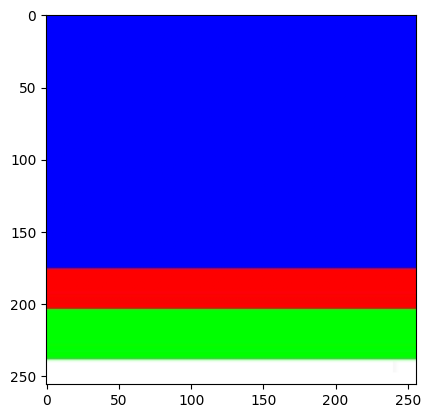

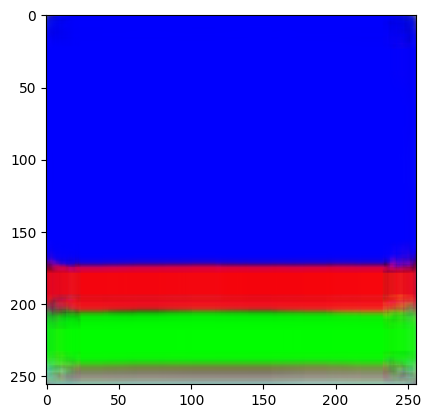

[39,     1] loss: 0.061
[39,     5] loss: 0.057
[39,     9] loss: 0.058
[39,    13] loss: 0.059
[39,    17] loss: 0.059
[39,    21] loss: 0.059
[39,    25] loss: 0.059
[39,    29] loss: 0.059
[39,    33] loss: 0.059
[39,    37] loss: 0.059
[39,    41] loss: 0.059
[39,    45] loss: 0.058
[39,    49] loss: 0.059
[39,    53] loss: 0.059
[39,    57] loss: 0.058
[39,    61] loss: 0.059
[39,    65] loss: 0.059
[39,    69] loss: 0.059
[39,    73] loss: 0.059
[39,    77] loss: 0.059
[39,    81] loss: 0.058
[39,    85] loss: 0.058
[39,    89] loss: 0.058
[39,    93] loss: 0.058
[39,    97] loss: 0.058
[39,   101] loss: 0.058
[39,   105] loss: 0.058
[39,   109] loss: 0.058
[39,   113] loss: 0.058
[39,   117] loss: 0.058
[39,   121] loss: 0.058
validation
LOSS valid 0.06027551740407944
[40,     1] loss: 0.061
[40,     5] loss: 0.061
[40,     9] loss: 0.059
[40,    13] loss: 0.059
[40,    17] loss: 0.058
[40,    21] loss: 0.057
[40,    25] loss: 0.057
[40,    29] loss: 0.057
[40,    33] loss: 0.05

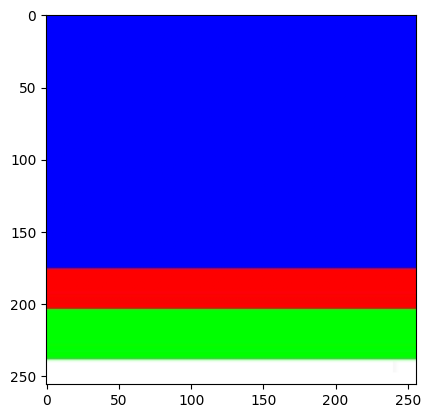

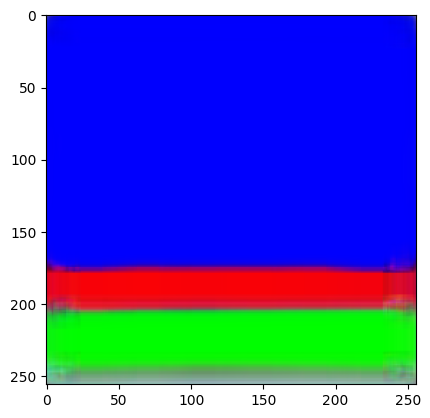

[41,     1] loss: 0.059
[41,     5] loss: 0.058
[41,     9] loss: 0.059
[41,    13] loss: 0.060
[41,    17] loss: 0.060
[41,    21] loss: 0.059
[41,    25] loss: 0.059
[41,    29] loss: 0.059
[41,    33] loss: 0.058
[41,    37] loss: 0.058
[41,    41] loss: 0.058
[41,    45] loss: 0.058
[41,    49] loss: 0.058
[41,    53] loss: 0.058
[41,    57] loss: 0.058
[41,    61] loss: 0.058
[41,    65] loss: 0.058
[41,    69] loss: 0.058
[41,    73] loss: 0.057
[41,    77] loss: 0.057
[41,    81] loss: 0.057
[41,    85] loss: 0.057
[41,    89] loss: 0.057
[41,    93] loss: 0.057
[41,    97] loss: 0.057
[41,   101] loss: 0.057
[41,   105] loss: 0.057
[41,   109] loss: 0.057
[41,   113] loss: 0.057
[41,   117] loss: 0.057
[41,   121] loss: 0.057
validation
LOSS valid 0.05877237766981125
check


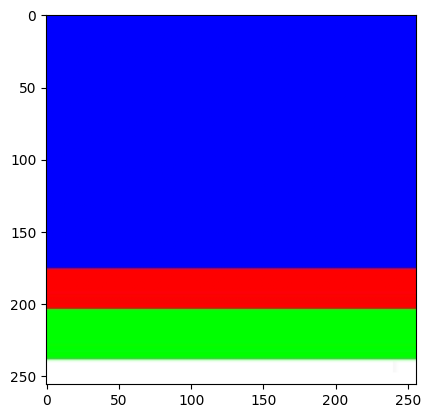

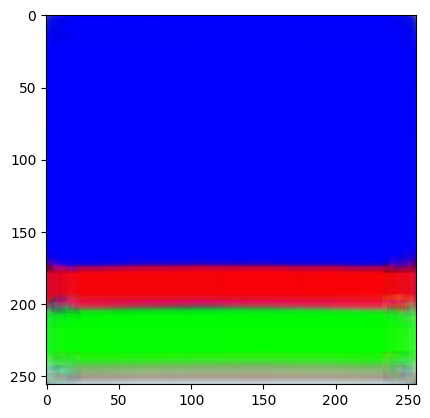

[42,     1] loss: 0.049
[42,     5] loss: 0.056
[42,     9] loss: 0.056
[42,    13] loss: 0.056
[42,    17] loss: 0.055
[42,    21] loss: 0.055
[42,    25] loss: 0.055
[42,    29] loss: 0.056
[42,    33] loss: 0.056
[42,    37] loss: 0.056
[42,    41] loss: 0.056
[42,    45] loss: 0.056
[42,    49] loss: 0.056
[42,    53] loss: 0.056
[42,    57] loss: 0.056
[42,    61] loss: 0.056
[42,    65] loss: 0.057
[42,    69] loss: 0.057
[42,    73] loss: 0.057
[42,    77] loss: 0.057
[42,    81] loss: 0.057
[42,    85] loss: 0.057
[42,    89] loss: 0.057
[42,    93] loss: 0.057
[42,    97] loss: 0.057
[42,   101] loss: 0.057
[42,   105] loss: 0.057
[42,   109] loss: 0.057
[42,   113] loss: 0.057
[42,   117] loss: 0.057
[42,   121] loss: 0.057
validation
LOSS valid 0.06038985773921013
[43,     1] loss: 0.057
[43,     5] loss: 0.059
[43,     9] loss: 0.059
[43,    13] loss: 0.057
[43,    17] loss: 0.058
[43,    21] loss: 0.056
[43,    25] loss: 0.057
[43,    29] loss: 0.057
[43,    33] loss: 0.05

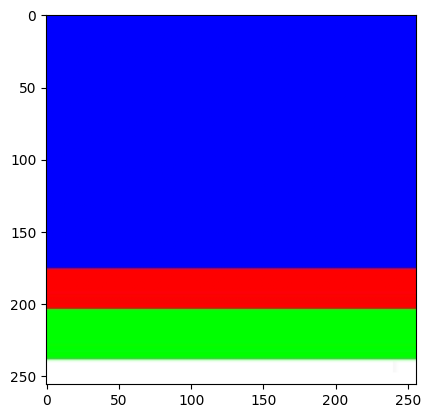

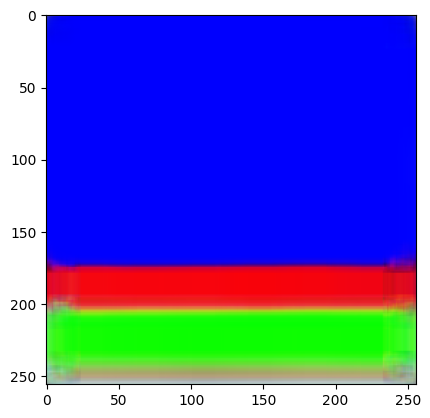

[48,     1] loss: 0.066
[48,     5] loss: 0.059
[48,     9] loss: 0.058
[48,    13] loss: 0.057
[48,    17] loss: 0.056
[48,    21] loss: 0.056
[48,    25] loss: 0.056
[48,    29] loss: 0.055
[48,    33] loss: 0.055
[48,    37] loss: 0.055
[48,    41] loss: 0.055
[48,    45] loss: 0.055
[48,    49] loss: 0.055
[48,    53] loss: 0.055
[48,    57] loss: 0.056
[48,    61] loss: 0.056
[48,    65] loss: 0.056
[48,    69] loss: 0.056
[48,    73] loss: 0.056
[48,    77] loss: 0.056
[48,    81] loss: 0.056
[48,    85] loss: 0.056
[48,    89] loss: 0.057
[48,    93] loss: 0.057
[48,    97] loss: 0.057
[48,   101] loss: 0.057
[48,   105] loss: 0.057
[48,   109] loss: 0.057
[48,   113] loss: 0.057
[48,   117] loss: 0.057
[48,   121] loss: 0.057
validation
LOSS valid 0.05835813656449318
check


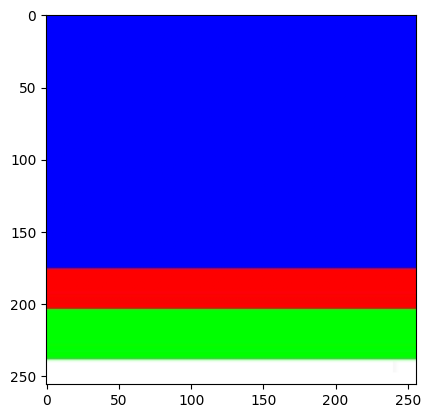

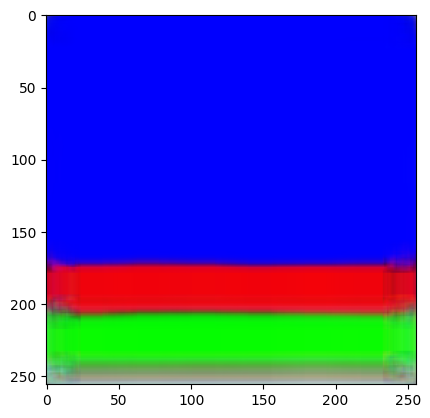

[49,     1] loss: 0.061
[49,     5] loss: 0.058
[49,     9] loss: 0.059
[49,    13] loss: 0.056
[49,    17] loss: 0.057
[49,    21] loss: 0.057
[49,    25] loss: 0.057
[49,    29] loss: 0.056
[49,    33] loss: 0.056
[49,    37] loss: 0.056
[49,    41] loss: 0.056
[49,    45] loss: 0.056
[49,    49] loss: 0.057
[49,    53] loss: 0.057
[49,    57] loss: 0.057
[49,    61] loss: 0.056
[49,    65] loss: 0.057
[49,    69] loss: 0.056
[49,    73] loss: 0.056
[49,    77] loss: 0.056
[49,    81] loss: 0.056
[49,    85] loss: 0.056
[49,    89] loss: 0.056
[49,    93] loss: 0.056
[49,    97] loss: 0.056
[49,   101] loss: 0.056
[49,   105] loss: 0.056
[49,   109] loss: 0.056
[49,   113] loss: 0.056
[49,   117] loss: 0.056
[49,   121] loss: 0.056
validation
LOSS valid 0.058529842644929886
[50,     1] loss: 0.056
[50,     5] loss: 0.058
[50,     9] loss: 0.056
[50,    13] loss: 0.056
[50,    17] loss: 0.056
[50,    21] loss: 0.055
[50,    25] loss: 0.055
[50,    29] loss: 0.055
[50,    33] loss: 0.0

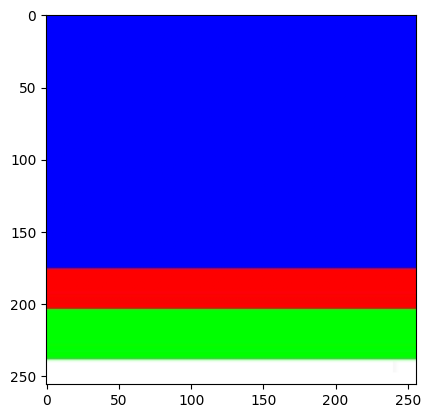

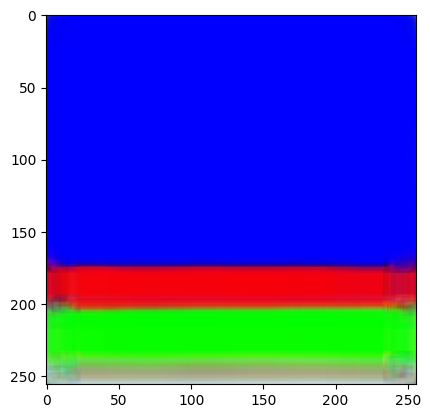

[53,     1] loss: 0.055
[53,     5] loss: 0.058
[53,     9] loss: 0.058
[53,    13] loss: 0.057
[53,    17] loss: 0.058
[53,    21] loss: 0.057
[53,    25] loss: 0.057
[53,    29] loss: 0.057
[53,    33] loss: 0.057
[53,    37] loss: 0.057
[53,    41] loss: 0.057
[53,    45] loss: 0.056
[53,    49] loss: 0.056
[53,    53] loss: 0.056
[53,    57] loss: 0.056
[53,    61] loss: 0.056
[53,    65] loss: 0.056
[53,    69] loss: 0.056
[53,    73] loss: 0.056
[53,    77] loss: 0.056
[53,    81] loss: 0.056
[53,    85] loss: 0.055
[53,    89] loss: 0.055
[53,    93] loss: 0.055
[53,    97] loss: 0.055
[53,   101] loss: 0.055
[53,   105] loss: 0.055
[53,   109] loss: 0.055
[53,   113] loss: 0.056
[53,   117] loss: 0.055
[53,   121] loss: 0.055
validation
LOSS valid 0.057997990399599075
[54,     1] loss: 0.064
[54,     5] loss: 0.057
[54,     9] loss: 0.056
[54,    13] loss: 0.058
[54,    17] loss: 0.058
[54,    21] loss: 0.058
[54,    25] loss: 0.058
[54,    29] loss: 0.058
[54,    33] loss: 0.0

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import math

def show_image(img):
    img = img.permute(1, 2, 0).numpy()
    plt.imshow( img )
    plt.show()


min_loss = float('inf')
patience_counter = 0
for epoch in range(100):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs = data.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = decoder(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 4 == 0:
          print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i + 1):.3f}')

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    decoder.eval()

    # Disable gradient computation and reduce memory consumption.
    print("validation")
    with torch.no_grad():
        for i, vdata in enumerate(val_loader):
            inputs = vdata.to(device)
            voutputs = decoder(inputs)
            vloss = criterion(voutputs, inputs)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS valid {}'.format(avg_vloss))
    if(avg_vloss < min_loss):
      min_loss = avg_vloss
      patience_counter = 0
      torch.save(decoder, '/content/drive/MyDrive/autoencoderv4.pt')
      print("check")
      img = val[1]
      show_image(img)
      img = np.expand_dims(img, axis=0)
      img = torch.Tensor(img).to(device)
      with torch.no_grad():
          prediction = decoder(img).squeeze().cpu()
          show_image(prediction)
    else:
      patience_counter += 1
    if patience_counter > 5:
      print("Early stopping")
      break


print('Finished Training')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# from PIL import Image
# import os


# _, _, files = next(os.walk('./masks'))
# for file in files:
#     path = f'./masks/{file}'
#     print(path)
#     image = Image.open(path)
#     new = image.resize((256,256)).convert('RGB')
#     new.save(path)

